# Capstone Project

## Import Libraries and set environment

In [21]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import sagemaker
import boto3
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

c:\Users\Momas\miniconda3\envs\gluon\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\Momas\AppData\Local\sagemaker\sagemaker\config.yaml


In [ ]:
# Set environment variables 
session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = "capstone4910"
prefix = "data/"

## Explore data

In [18]:
# Import data
dataset = pd.read_csv("data/ecoli_structure_filtered.csv")
dataset.head()

,...1,bacterium,modifications,sequence,strain,unit,url_source,log(MIC),pMIC,is_modified,...,sequence_len,id,secondary_structure,len,helix_group,sheet_group,coil_group,helix_percentage,sheet_percentage,coil_percentage
0,2112,E. coli,[],AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS,ATCC 25922,uM,https://dbaasp.org/peptide-card?id=5613,2.10,3.90,False,...,33,GRAMPA_1984,CCCHHHHHHHCCCHHHHHHHHHHHHHHHHHCCC,33,70-80,0-10,20-30,72.73,0.00,27.27
1,5527,E. coli,[C-Terminus: AMD],AAAAAAAIKMLMDLVNERIMALNKKAKK,ATCC 25922,uM,https://dbaasp.org/peptide-card?id=7719,1.00,5.00,True,...,28,GRAMPA_5154,CCCHHHHHHHHHHHHHHHHHHHHHHCCC,28,70-80,0-10,20-30,78.57,0.00,21.43
2,7671,E. coli,[],AAAAGSVWGAVNYTSDCNGECKRRGYKGGYCGSFANVNCWCET,NaN,uM,http://www.yadamp.unisa.it/showItem.aspx?yadam...,2.00,4.00,False,...,43,GRAMPA_5919,CCCCCCCECCCCECCCHHHHHHHCCCCEEEEECCCCCEEEEEC,43,10-20,20-30,50-60,16.28,27.91,55.81
3,3562,E. coli,[],AAAKAALNAVLVGANA,TG1,uM,https://dbaasp.org/peptide-card?id=618,1.90,4.10,False,...,16,GRAMPA_3326,CCCHHHHHHHHHCCCC,16,50-60,0-10,40-50,56.25,0.00,43.75
4,5678,E. coli,[],AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC,NaN,uM,https://dbaasp.org/peptide-card?id=5171,0.25,5.75,False,...,40,GRAMPA_5298,CCCCCCCCCCCECCCCCCCCCCCCCCEEEECECHHCCCCC,40,0-10,10-20,70-80,5.00,15.00,80.00


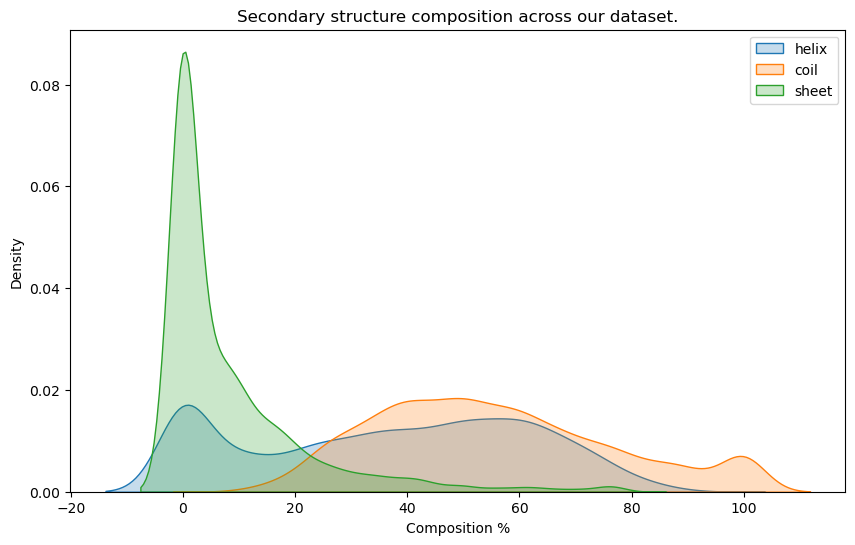

In [6]:
# Create figure and axis
plt.figure(figsize=(10, 6))

# Density plots for secondary structure composition 
sns.kdeplot(dataset["helix_percentage"], label="helix", fill=True) #kde: Kernel Density Estimate
sns.kdeplot(dataset["coil_percentage"], label="coil", fill=True)
sns.kdeplot(dataset["sheet_percentage"], label="sheet", fill=True)

# Customize the plot
plt.title("Secondary structure composition across our dataset.")
plt.xlabel("Composition %")
plt.legend()

# Show plot
plt.show()

In [19]:
dataset.shape

(4540, 24)

## Prepare data

### Split the data

In [22]:
# The inputs to create the Dataset are numpy arrays

X = np.array(dataset["sequence"])
y = np.array(dataset["pMIC"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
#%store X_train
#%store X_test
#%store y_train
#%store y_test

Stored 'X_train' (ndarray)
Stored 'X_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)


In [3]:
%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test

### Save datasets for each split
We'll save each data split in a separate named directory so we can have more control to how we pass data to the traininng/HPO jobs

In [92]:
# Transform back to df
train_df = pd.DataFrame(X_train)
train_df["pMIC"] = y_train
train_df = train_df.rename(columns={0: "sequence"})

val_df = pd.DataFrame(X_test)
val_df["pMIC"] = y_test
val_df = val_df.rename(columns={0: "sequence"})

In [94]:
# Save each split as CSV files
train_df.to_csv("data/train/ecoli_train_im.csv", index=False)
val_df.to_csv("data/validation/ecoli_val_im.csv", index=False)

In [25]:
torch.__version__

'2.3.1+cpu'

In [9]:
from torch.nn import MSELoss

#### ----------

In [14]:
%time
# Fit model
train(my_model, train_loader, test_loader, optimizer, epochs, device, criterion=loss_fn)

CPU times: total: 0 ns
Wall time: 0 ns
Starting training.
Starting training.
Model moved to cpu
Model moved to cpu


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.008
Epoch 1/10, Training Loss: 0.008
Epoch 1/10, Training MSE: 0.961
Epoch 1/10, Training MSE: 0.961
Epoch 1/10, Training R2: -0.67, Training RMSE: 0.980, Training MAE: 0.786
Epoch 1/10, Training R2: -0.67, Training RMSE: 0.980, Training MAE: 0.786
Validation started.
Validation started.
Epoch 1/10, Validation Loss: 0.009
Epoch 1/10, Validation Loss: 0.009
Epoch 1/10, Validation MSE: 1.040
Epoch 1/10, Validation MSE: 1.040
Epoch 1/10, Validation R2: -0.73, Validation RMSE: 1.020, Validation MAE: 0.835
Epoch 1/10, Validation R2: -0.73, Validation RMSE: 1.020, Validation MAE: 0.835


Training:  10%|█         | 1/10 [00:03<00:30,  3.43s/it]

Epoch 2/10, Training Loss: 0.006
Epoch 2/10, Training Loss: 0.006
Epoch 2/10, Training MSE: 0.735
Epoch 2/10, Training MSE: 0.735
Epoch 2/10, Training R2: -0.28, Training RMSE: 0.857, Training MAE: 0.693
Epoch 2/10, Training R2: -0.28, Training RMSE: 0.857, Training MAE: 0.693
Validation started.
Validation started.
Epoch 2/10, Validation Loss: 0.006
Epoch 2/10, Validation Loss: 0.006
Epoch 2/10, Validation MSE: 0.629
Epoch 2/10, Validation MSE: 0.629
Epoch 2/10, Validation R2: -0.05, Validation RMSE: 0.793, Validation MAE: 0.638
Epoch 2/10, Validation R2: -0.05, Validation RMSE: 0.793, Validation MAE: 0.638


Training:  20%|██        | 2/10 [00:05<00:22,  2.81s/it]

Epoch 3/10, Training Loss: 0.005
Epoch 3/10, Training Loss: 0.005
Epoch 3/10, Training MSE: 0.599
Epoch 3/10, Training MSE: 0.599
Epoch 3/10, Training R2: -0.04, Training RMSE: 0.774, Training MAE: 0.633
Epoch 3/10, Training R2: -0.04, Training RMSE: 0.774, Training MAE: 0.633
Validation started.
Validation started.
Epoch 3/10, Validation Loss: 0.006
Epoch 3/10, Validation Loss: 0.006
Epoch 3/10, Validation MSE: 0.600
Epoch 3/10, Validation MSE: 0.600
Epoch 3/10, Validation R2: -0.00, Validation RMSE: 0.775, Validation MAE: 0.622
Epoch 3/10, Validation R2: -0.00, Validation RMSE: 0.775, Validation MAE: 0.622


Training:  30%|███       | 3/10 [00:08<00:18,  2.59s/it]

Epoch 4/10, Training Loss: 0.005
Epoch 4/10, Training Loss: 0.005
Epoch 4/10, Training MSE: 0.613
Epoch 4/10, Training MSE: 0.613
Epoch 4/10, Training R2: -0.07, Training RMSE: 0.783, Training MAE: 0.637
Epoch 4/10, Training R2: -0.07, Training RMSE: 0.783, Training MAE: 0.637
Validation started.
Validation started.
Epoch 4/10, Validation Loss: 0.006
Epoch 4/10, Validation Loss: 0.006
Epoch 4/10, Validation MSE: 0.612
Epoch 4/10, Validation MSE: 0.612
Epoch 4/10, Validation R2: -0.02, Validation RMSE: 0.782, Validation MAE: 0.630
Epoch 4/10, Validation R2: -0.02, Validation RMSE: 0.782, Validation MAE: 0.630


Training:  40%|████      | 4/10 [00:10<00:15,  2.55s/it]

Epoch 5/10, Training Loss: 0.005
Epoch 5/10, Training Loss: 0.005
Epoch 5/10, Training MSE: 0.618
Epoch 5/10, Training MSE: 0.618
Epoch 5/10, Training R2: -0.08, Training RMSE: 0.786, Training MAE: 0.641
Epoch 5/10, Training R2: -0.08, Training RMSE: 0.786, Training MAE: 0.641
Validation started.
Validation started.
Epoch 5/10, Validation Loss: 0.006
Epoch 5/10, Validation Loss: 0.006
Epoch 5/10, Validation MSE: 0.610
Epoch 5/10, Validation MSE: 0.610
Epoch 5/10, Validation R2: -0.02, Validation RMSE: 0.781, Validation MAE: 0.628
Epoch 5/10, Validation R2: -0.02, Validation RMSE: 0.781, Validation MAE: 0.628


Training:  50%|█████     | 5/10 [00:13<00:12,  2.54s/it]

Epoch 6/10, Training Loss: 0.005
Epoch 6/10, Training Loss: 0.005
Epoch 6/10, Training MSE: 0.583
Epoch 6/10, Training MSE: 0.583
Epoch 6/10, Training R2: -0.02, Training RMSE: 0.764, Training MAE: 0.624
Epoch 6/10, Training R2: -0.02, Training RMSE: 0.764, Training MAE: 0.624
Validation started.
Validation started.
Epoch 6/10, Validation Loss: 0.006
Epoch 6/10, Validation Loss: 0.006
Epoch 6/10, Validation MSE: 0.658
Epoch 6/10, Validation MSE: 0.658
Epoch 6/10, Validation R2: -0.10, Validation RMSE: 0.811, Validation MAE: 0.653
Epoch 6/10, Validation R2: -0.10, Validation RMSE: 0.811, Validation MAE: 0.653


Training:  60%|██████    | 6/10 [00:15<00:10,  2.51s/it]

Epoch 7/10, Training Loss: 0.005
Epoch 7/10, Training Loss: 0.005
Epoch 7/10, Training MSE: 0.623
Epoch 7/10, Training MSE: 0.623
Epoch 7/10, Training R2: -0.08, Training RMSE: 0.789, Training MAE: 0.645
Epoch 7/10, Training R2: -0.08, Training RMSE: 0.789, Training MAE: 0.645
Validation started.
Validation started.
Epoch 7/10, Validation Loss: 0.006
Epoch 7/10, Validation Loss: 0.006
Epoch 7/10, Validation MSE: 0.612
Epoch 7/10, Validation MSE: 0.612
Epoch 7/10, Validation R2: -0.02, Validation RMSE: 0.782, Validation MAE: 0.629
Epoch 7/10, Validation R2: -0.02, Validation RMSE: 0.782, Validation MAE: 0.629


Training:  70%|███████   | 7/10 [00:17<00:07,  2.44s/it]

Epoch 8/10, Training Loss: 0.005
Epoch 8/10, Training Loss: 0.005
Epoch 8/10, Training MSE: 0.617
Epoch 8/10, Training MSE: 0.617
Epoch 8/10, Training R2: -0.07, Training RMSE: 0.786, Training MAE: 0.638
Epoch 8/10, Training R2: -0.07, Training RMSE: 0.786, Training MAE: 0.638
Validation started.
Validation started.
Epoch 8/10, Validation Loss: 0.006
Epoch 8/10, Validation Loss: 0.006
Epoch 8/10, Validation MSE: 0.602
Epoch 8/10, Validation MSE: 0.602
Epoch 8/10, Validation R2: -0.00, Validation RMSE: 0.776, Validation MAE: 0.623
Epoch 8/10, Validation R2: -0.00, Validation RMSE: 0.776, Validation MAE: 0.623


Training:  80%|████████  | 8/10 [00:20<00:04,  2.41s/it]

Epoch 9/10, Training Loss: 0.005
Epoch 9/10, Training Loss: 0.005
Epoch 9/10, Training MSE: 0.620
Epoch 9/10, Training MSE: 0.620
Epoch 9/10, Training R2: -0.08, Training RMSE: 0.787, Training MAE: 0.639
Epoch 9/10, Training R2: -0.08, Training RMSE: 0.787, Training MAE: 0.639
Validation started.
Validation started.
Epoch 9/10, Validation Loss: 0.006
Epoch 9/10, Validation Loss: 0.006
Epoch 9/10, Validation MSE: 0.608
Epoch 9/10, Validation MSE: 0.608
Epoch 9/10, Validation R2: -0.01, Validation RMSE: 0.780, Validation MAE: 0.627
Epoch 9/10, Validation R2: -0.01, Validation RMSE: 0.780, Validation MAE: 0.627


Training:  90%|█████████ | 9/10 [00:22<00:02,  2.44s/it]

Epoch 10/10, Training Loss: 0.005
Epoch 10/10, Training Loss: 0.005
Epoch 10/10, Training MSE: 0.590
Epoch 10/10, Training MSE: 0.590
Epoch 10/10, Training R2: -0.03, Training RMSE: 0.768, Training MAE: 0.626
Epoch 10/10, Training R2: -0.03, Training RMSE: 0.768, Training MAE: 0.626
Validation started.
Validation started.
Epoch 10/10, Validation Loss: 0.006
Epoch 10/10, Validation Loss: 0.006
Epoch 10/10, Validation MSE: 0.610
Epoch 10/10, Validation MSE: 0.610
Epoch 10/10, Validation R2: -0.02, Validation RMSE: 0.781, Validation MAE: 0.627
Epoch 10/10, Validation R2: -0.02, Validation RMSE: 0.781, Validation MAE: 0.627


Training: 100%|██████████| 10/10 [00:25<00:00,  2.53s/it]

Finished training for 10s epochs.
Finished training for 10s epochs.


In [12]:
%time
test(my_model, test_loader, device)

CPU times: total: 0 ns
Wall time: 0 ns
Testing started.
Model moved to cpu


array([[4.993476 ],
       [4.993915 ],
       [4.9938846],
       [4.9938774],
       [4.9938803],
       [4.993802 ],
       [4.9939075],
       [4.9939384],
       [4.9938655],
       [4.993896 ],
       [4.993856 ],
       [4.9939156],
       [4.993891 ],
       [4.9939017],
       [4.9938936],
       [4.9938707],
       [4.993903 ],
       [4.9939117],
       [4.993925 ],
       [4.993866 ],
       [4.993892 ],
       [4.993915 ],
       [4.9938693],
       [4.9938793],
       [4.993909 ],
       [4.9937787],
       [4.993917 ],
       [4.9939194],
       [4.993925 ],
       [4.9939127],
       [4.9935646],
       [4.993812 ],
       [4.993917 ],
       [4.993903 ],
       [4.9939117],
       [4.99392  ],
       [4.993866 ],
       [4.9938807],
       [4.9939117],
       [4.9939113],
       [4.9939027],
       [4.9939127],
       [4.9938955],
       [4.993901 ],
       [4.993922 ],
       [4.9939156],
       [4.9938645],
       [4.9939184],
       [4.993881 ],
       [4.9939203],


### Upload data to S3

In [ ]:
# Upload data 
training_inputs = session.upload_data(path="data/train/ecoli_train_im.csv", bucket=bucket, key_prefix=prefix + "train")
validation_inputs = session.upload_data(path="data/validation/ecoli_val_im.csv", bucket=bucket, key_prefix=prefix + "validation")

Define the inputs to the HPO job

In [ ]:
# Set the input channels usig the URIs from the uplpoad
inputs = {'training': training_inputs,
          'validation': validation_inputs}

In [ ]:
inputs

## Perform Hyperparameter Optimization

### Instance the Estimator
We can use utility custom code when launching a training job. For that we must 

In [ ]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo_im.py",
    source_dir="s3://capstone4910/project.tar.gz", #to use custom modular code
    role=role,
    py_version="py310",
    framework_version="2.2",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

### Configure hyperparameter tuner

The metric_definitions parameter is crucial when using SageMaker’s Hyperparameter Tuner, as it tells the tuner how to interpret and extract metrics from the training output logs. The regular expression is used to search the output logs for the metric.

In [ ]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1), # (min, max)
    "batch_size": CategoricalParameter([64, 128, 256]),
    "epochs": IntegerParameter(5, 10) # (min, max)
}

objective_metric_name = "Validation MSE"
objective_type = "Minimize"
metric_definitions = [{"Name": "Validation MSE",
                      "Regex": "Validation MSE: ([0-9\\.]+)"}]

#Instnace hyperparameter tuner
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=1,
    max_parallel_jobs=1,
    objective_type=objective_type,
    base_tuning_job_name="hpo-ecoli-im01"
)

In [ ]:
%time
tuner.fit(inputs, wait=True)

In [ ]:
# Get the hyperparams from the best run
best_estimator = tuner.best_estimator()

best_hyperparams = best_estimator.hyperparameters()
best_hyperparams

In [ ]:
# Retrieve each hyperparam
batch_size = str(best_hyperparams.get("batch_size", ""))
epochs = str(best_hyperparams.get("epochs", ""))
learning_rate = str(best_hyperparams.get("learning_rate", ""))

print(f"Batch size: {batch_size}, Epochs: {epochs}, Learning rate: {learning_rate}")

## Model Profiling and debugging

### Set hyperparmeters for our training job
We'll train our model with the best hyperparameters from the last HPO training jobs.

In [ ]:
# Set hyperparams for the training job, this can also be done in a script
hyperparameters = {
    "batch_size": 64,
    "epochs": 10,
    "learning_rate": 0.02
}

#### Key concepts of Amazon SageMaker Debugger

Amazon SageMaker Debugger lets you go beyond just looking at scalars like losses and accuracies during training and gives you full visibility into all tensors 'flowing through the graph' during training. Furthermore, it helps you monitor your training in near real time using rules and provides you alerts, once it has detected inconsistency in training flow.

Concepts
- Tensors: These represent the state of the training network at intermediate points during its execution
- Debug Hook: Hook is the construct with which Amazon SageMaker Debugger looks into the training process and captures the tensors requested at the desired step intervals
- Rule: A logical construct, implemented as Python code, which helps analyze the tensors captured by the hook and report anomalies, if at all



#### Create rules and hooks 

In [ ]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

# Create profiling and debugging rules
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [ ]:
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

# Set profiler and debugger configs
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10) #i)?
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"} #i) ?
)

### Launch a Trainig Job in SageMaker

#### Create the PT estimator

In [ ]:
from sagemaker.pytorch import PyTorch
#role = sagemaker.get_execution_role()

estimator = PyTorch(
    base_job_name="train-eco-im01", #Change for every training job
    role=role,
    entry_point="train_eco_im.py",
    instance_type="ml.g4dn.xlarge",
    instance_count=1,
    framework_version=2.2,
    py_version="py310",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

#### Train the estimator

In [ ]:
inputs = {"training": training_inputs,
          "test": validation_inputs}

In [ ]:
%%time
# Train our model
estimator.fit(inputs, wait=True)

Prepare for debugging and profiling analysis [required? Maybe just display the report]

## Deploy the trained model

## Perform inference on the testing data